In [1]:
import os
import sys
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import keras
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.utils.vis_utils import plot_model
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%%capture --no-display

# run once
nltk.download('stopwords'), nltk.download('punkt'), nltk.download('wordnet')

(True, True, True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peilingjiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/peilingjiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/peilingjiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Data Preparation

In [3]:
def read_data(file):
    '''
    Read each text file into a string
    '''
    f = open(file, 'r', encoding='utf-8')
    text = f.read()
    f.close()
    return text


def folder_list(path):
    '''
    Reads each text file in a folder and concatenates each file into a bigger string
    Parameter 'path' is the path of your local folder
    '''
    filelist = os.listdir(path)
    text = ''
    for infile in filelist:
        file = os.path.join(path, infile)
        text_data = read_data(file)
        text += '\n ' + text_data
    return text


def load_and_shuffle_data():
    path = "data/"

    text = folder_list(path)
    # print(text)
    # random.shuffle(text)

    return text

In [4]:
data = load_and_shuffle_data()
# print(data)

# 2. Text Preprocessing

### a. Expand Contractions

Expand the contractions in the sentences, e.g., change *I'm* to *I am*.

In [7]:
sys.path.append('./helpers/')
from contraction_map import *

In [8]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(
        contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        #print(match)
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        #print(expanded_contraction)
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [9]:
# test
print(expand_contractions('''test: it's I'll I'm haven't''', CONTRACTION_MAP))

test: it is I will I am have not


### b. Remove non-alphabetical characters

Remove special characters like periods, commas, as well as digits. Only keep the alphabet characters and spaces.

In [10]:
def remove_non_alphabetical_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [11]:
# test
print(
    remove_non_alphabetical_characters('t !@#$%^&*()_+-={}[]:"e;'
                                       '">? s ./\|<>,t1234567890`'))

t e s t


### c. Removing stopwords

Remove all stop words, e.g., *a*, *the*, *and*, etc.

In [12]:
def remove_stopwords(text):
    stopword_list = set(stopwords.words('english'))

    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]

    filtered_tokens = [token for token in tokens if token not in stopword_list]

    return ' '.join(filtered_tokens)

In [13]:
# test
print(remove_stopwords('this test is a test to test the test from a test'))

test test test test test


### d. Stemming 

Stem the words, e.g., change *making* to *make*. **(May remove due to aggressive pruning issue + lemma being more effective.)**

In [19]:
def stemmer_text_1(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [23]:
def stemmer_text_2(text):
    ps = nltk.stem.SnowballStemmer('english')
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [25]:
# Stemmer
# issue with stemming - https://medium.com/@tusharsri/nlp-a-quick-guide-to-stemming-60f1ca5db49e
print(stemmer_text_1('making make makes try tries ponies us leaves happiness ate gone this'))
print(stemmer_text_2('making make makes try tries ponies us leaves happiness ate gone this'))

make make make tri tri poni us leav happi ate gone thi
make make make tri tri poni us leav happi ate gone this


### e. Lemmatization

Lemmatize words with knowing context, e.g., change *making* to *make*.

In [28]:
def lemmatize_text(text):
    wn_lemmatizer = WordNetLemmatizer()
    text = ' '.join([wn_lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [29]:
#test
print(lemmatize_text('making make makes'))
print(lemmatize_text('try tries ponies us'))

making make make
try try pony u


### PREPROCESS

In [30]:
def preprocess(text):
    text = text.lower()
    text = expand_contractions(text)
    text = remove_non_alphabetical_characters(text)
    # text = remove_stopwords(text)
    # text = stemmer_text(text)
    text = lemmatize_text(text)
    return text

In [31]:
preprocessed_text = preprocess(data)
# print(preprocessed_text)

In [32]:
tokens = preprocessed_text.split()
print('Number of words: ' + str(len(tokens)))
print('Number of unique words: ' + str(len(set(tokens))))

Number of words: 243442
Number of unique words: 11892


# 3. Sequence of words + integer encoding 

In [50]:
# Load all tokens into sequences (so that model can learn to predict words after a given sequence)
# See https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i - length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 243391


In [51]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


out_filename = 'sequences50_new.txt'
save_doc(sequences, out_filename)

# 4. Train model

In [4]:
import keras


# used to save the keras model every 10 epochs
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model3_{}.hd5".format(epoch))

In [5]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


# load
in_filename = 'sequences50_new.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [6]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# separate into input and output
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [7]:
# define model
model = Sequential()
model.add(Embedding(
    vocab_size, 50,
    input_length=seq_length))  #create word embedding, better than BoW
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))  # dropout to reduce overfitting
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# fit model
saver = CustomSaver()
history = model.fit(X,
                    y,
                    callbacks=[saver],
                    batch_size=128,
                    epochs=100,
                    validation_split=0.2,
                    shuffle=True)

# model.save('model50.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            594650    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)              

C:\Users\Jonathan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 194712 samples, validate on 48679 samples
Epoch 1/100
194712/194712 [==============================] - 707s 4ms/step - loss: 6.5176 - accuracy: 0.0583 - val_loss: 6.5301 - val_accuracy: 0.0757
Epoch 2/100
194712/194712 [==============================] - 702s 4ms/step - loss: 6.1433 - accuracy: 0.0707 - val_loss: 6.4444 - val_accuracy: 0.0869
Epoch 3/100
194712/194712 [==============================] - 856s 4ms/step - loss: 5.9054 - accuracy: 0.0913 - val_loss: 6.3899 - val_accuracy: 0.1015
Epoch 4/100
194712/194712 [==============================] - 722s 4ms/step - loss: 5.7325 - accuracy: 0.1038 - val_loss: 6.4149 - val_accuracy: 0.1054
Epoch 5/100
194712/194712 [==============================] - 701s 4ms/step - loss: 5.5989 - accuracy: 0.1113 - val_loss: 6.4473 - val_accuracy: 0.1092
Epoch 6/100
194712/194712 [==============================] - 704s 4ms/step - loss: 5.4926 - accuracy: 0.1169 - val_loss: 6.5115 - val_accuracy: 0.1092
Epoch 7/100
194712/194712 [================

In [8]:
model.save('model3_100.h5')

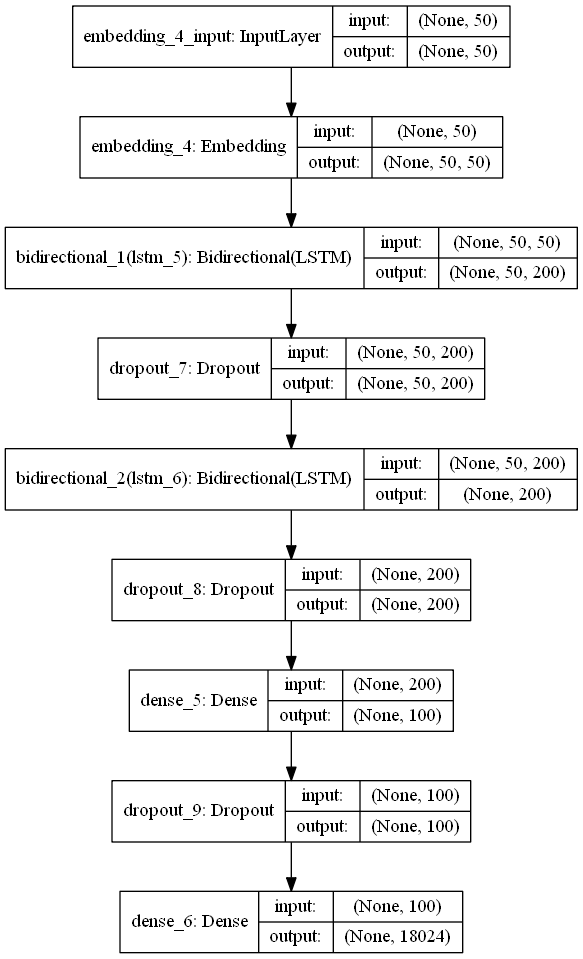

In [43]:
plot_model(model,
           to_file='model_new.png',
           show_shapes=True,
           show_layer_names=True)

## 4b. Training analysis

In [9]:
df = pd.DataFrame()
df['epoch'] = range(100)
df['train_loss'] = history.history['loss']
df['train_acc'] = history.history['accuracy']
df['val_loss'] = history.history['val_loss']
df['val_acc'] = history.history['val_accuracy']

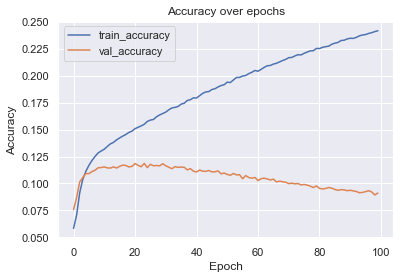

In [10]:
sns.set(style="darkgrid")
plt.plot(range(100), history.history['accuracy'], label='train_accuracy')
plt.plot(range(100), history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

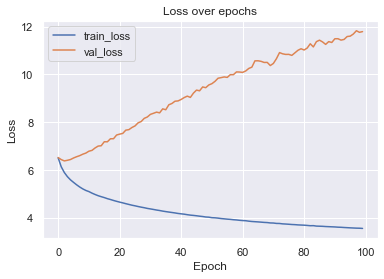

In [11]:
plt.plot(range(100), history.history['loss'], label='train_loss')
plt.plot(range(100), history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

# 5. Text generation (after training)

In [12]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [13]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [14]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):

    result = list()
    in_text = seed_text

    # generate a fixed number of words
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences(
            [in_text])[0]  # encode the text as integer
        encoded = pad_sequences(
            [encoded], maxlen=seq_length,
            truncating='pre')  # truncate sequences to a fixed length
        yhat = model.predict_classes(
            encoded, verbose=0)  # predict probabilities for each word

        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break

        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [15]:
# load cleaned text sequences
in_filename = 'sequences50_new.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

# a. Earlier model (trained for 1 epoch)

In [72]:
# load the model
model = load_model('model3_0.hd5')

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# select a random seed text
seed_text = lines[randint(0, len(lines))]
print(seed_text + '\n')

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

C:\Users\Jonathan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


she heard it muttering to itself the duchess the duchess oh my dear paw oh my fur and whisker shell get me executed a sure a ferret are ferret where can i have dropped them i wonder alice guessed in a moment that it wa looking for the fan and the

little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little


# b. Supposed best model (trained for 20 epochs)

**- has lowest validation error**

In [73]:
# load the model
model = load_model('model3_20.hd5')

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

C:\Users\Jonathan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


she heard it muttering to itself the duchess the duchess oh my dear paw oh my fur and whisker shell get me executed a sure a ferret are ferret where can i have dropped them i wonder alice guessed in a moment that it wa looking for the fan and the

captain wa a little deal of the other thing and the captain wa a little little girl and the lion wa a little little girl and the scarecrow wa a little man and the lion wa a little a the lion and the lion wa a great man and the


# c. Final model (trained for 100 epochs)

In [74]:
# load the model
model = load_model('model3_100.h5')

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

C:\Users\Jonathan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


she heard it muttering to itself the duchess the duchess oh my dear paw oh my fur and whisker shell get me executed a sure a ferret are ferret where can i have dropped them i wonder alice guessed in a moment that it wa looking for the fan and the

other thing wa a little pattering of the deepest hound contempt a man a he wa a curious idea that wa a little a the benefit of his head and looked at the tree and the lion played and the little house of the tree and the little old woman
